In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
name = 'test_model_2'

In [4]:
path = 'data/yrec_grid.h5'
h5f = h5py.File(path, 'r')

dset = h5f['data']
data = np.array(dset)
columns = dset.attrs['columns']

h5f.close()

In [5]:
df = pd.DataFrame(data, columns=columns)
del data

In [6]:
df.head()

,EEP,M/Msun,Age(Gyr),[Fe/H],fk,Rocrit,Prot(days),log(Teff)(K),R/Rsun,log(Z/X)(surface)
0,1.000000,1.06,0.036089,0.1,6.0,2.75,0.374777,3.752937,0.987328,-1.692670
1,1.045365,1.06,0.037402,0.1,6.0,2.75,0.383608,3.751863,0.979282,-1.692682
2,1.067487,1.06,0.039110,0.1,6.0,2.75,0.395994,3.751114,0.975430,-1.692698
3,1.069806,1.06,0.041330,0.1,6.0,2.75,0.412794,3.750794,0.975226,-1.692721
4,1.079711,1.06,0.044216,0.1,6.0,2.75,0.435389,3.750821,0.976990,-1.692753


In [7]:
len(df)

48158961

In [9]:
mask = (df['Prot(days)'] == 0)
len(df.loc[mask])

99120

In [10]:
df.drop(df.loc[mask].index, inplace=True)

In [11]:
df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
df['[Fe/H](surface)'] = df['log(Z/X)(surface)'] - np.log10(SOLAR_ZX)

In [12]:
df['log(Prot)(days)'] = np.log10(df['Prot(days)'])

In [13]:
df['log(Age)(Gyr)'] = np.log10(df['Age(Gyr)'])

In [14]:
# non_diff = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].to_numpy() == df.loc[df['EEP'] == 2, '[Fe/H](surface)'].to_numpy()
# np.sum(non_diff)

In [15]:
# start = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].index.to_numpy()
# stop = df.loc[df['EEP'] == 3, '[Fe/H](surface)'].index.to_numpy()

In [16]:
# non_diff_idx = np.concatenate([np.arange(st, sp+1, dtype=int) for st, sp in zip(start[non_diff], stop[non_diff])])

In [17]:
# len(non_diff_idx) / len(df)

In [18]:
# len(df) - len(non_diff_idx)

In [19]:
# df.drop(non_diff_idx, inplace=True)

In [20]:
# len(df)

In [21]:
random_state = 2

train = df.sample(frac=0.8, random_state=random_state)
test = df.drop(train.index)

In [22]:
print('Train length = ', len(train))
print('Test length = ', len(test))

Train length =  38447873
Test length =  9611968


In [23]:
del df

In [24]:
input_cols = ['log(Age)(Gyr)', 'M/Msun', '[Fe/H]', 'fk', 'Rocrit']
output_cols = ['log(Prot)(days)']

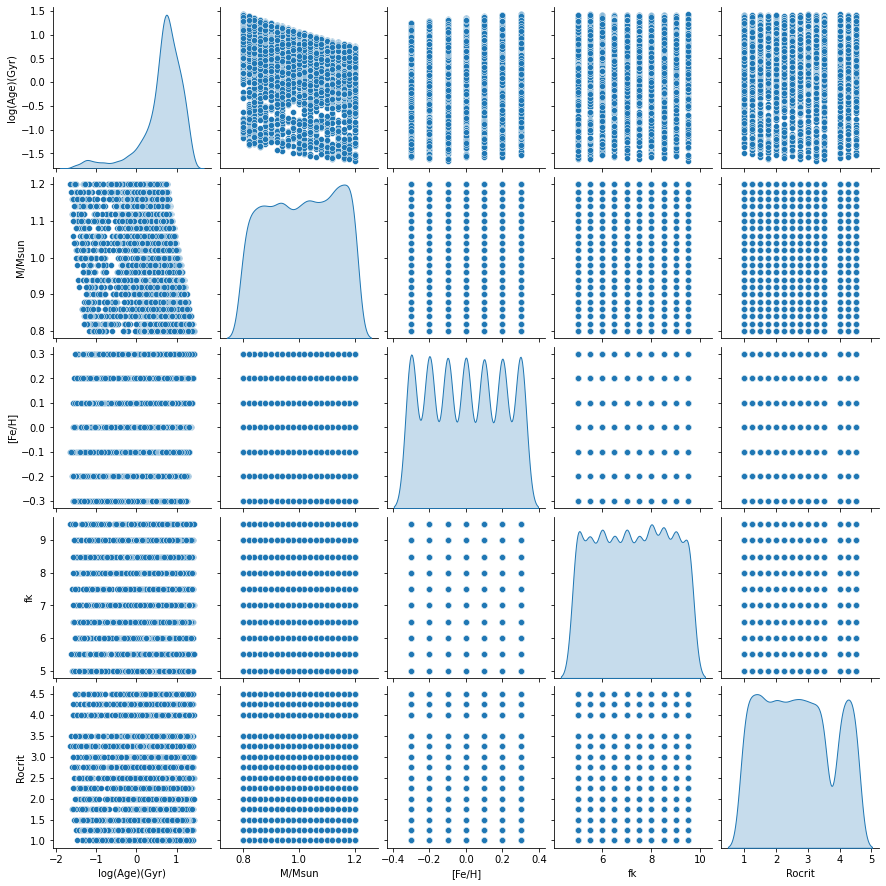

In [25]:
sns.pairplot(train[input_cols].sample(10000), diag_kind='kde');

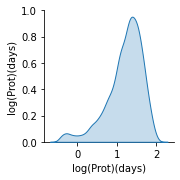

In [26]:
sns.pairplot(train[output_cols].sample(10000), diag_kind='kde');

In [27]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

In [28]:
input_mean = input_normalizer.mean.numpy()
input_var = input_normalizer.variance.numpy()
for col, mean, var in zip(input_cols, input_mean, input_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Age)(Gyr)  : 6.385e-01, 2.842e-01
M/Msun         : 1.008e+00, 1.474e-02
[Fe/H]         : -2.550e-03, 3.995e-02
fk             : 7.250e+00, 2.062e+00
Rocrit         : 2.679e+00, 1.173e+00


In [29]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

In [30]:
output_mean = output_normalizer.mean.numpy()
output_var = output_normalizer.variance.numpy()
for col, mean, var in zip(output_cols, output_mean, output_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Prot)(days): 1.195e+00, 2.106e-01


In [31]:
output_rescaler = preprocessing.Rescaling(scale=np.sqrt(output_var), 
                                          offset=output_mean)

In [32]:
def build_model(n_neurons, n_hidden, activation='elu', l2_reg=0.0):
    reg = regularizers.L2(l2_reg)
    hidden_layers = [layers.Dense(n_neurons, 
                                  activation=activation, 
                                  kernel_regularizer=reg) for layer in range(n_hidden)]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    model = keras.Sequential(all_layers)
    return model

In [33]:
model = build_model(128, 8, l2_reg=0.0)

In [34]:
model.save(f'data/models/{name}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: data/models/test_model_2/assets


In [41]:
learning_rate = 1e-4
momentum = 0.999

model.compile(loss='mean_squared_error',
             optimizer=keras.optimizers.SGD(learning_rate, momentum=momentum),
#              optimizer=keras.optimizers.Adam(learning_rate)
             )

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [43]:
batch_size = 8192*2

print('Number of batches:', len(train)//batch_size)
print('Remainder:', len(train)%batch_size)

Number of batches: 2346
Remainder: 11009


In [46]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=0.2,
    batch_size=batch_size,
    verbose=0, epochs=100,
)

CPU times: user 32min 6s, sys: 2min 50s, total: 34min 57s
Wall time: 14min 38s


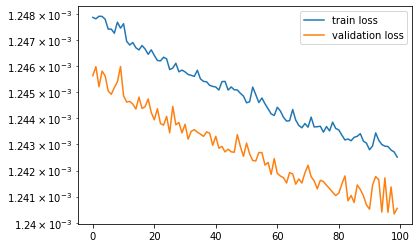

In [47]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')

plt.yscale('log')
plt.legend()

In [48]:
model.save(f'data/models/{name}')

INFO:tensorflow:Assets written to: data/models/test_model_2/assets


In [49]:
pred = pd.DataFrame(model(test[input_cols]).numpy(), columns=output_cols)
pred.head()

,log(Prot)(days)
0,-0.415835
1,-0.001199
2,0.144644
3,0.798468
4,0.888035


In [50]:
truth = test[output_cols].reset_index(drop=True)
error = truth - pred
frac_error = (truth - pred) / truth

In [51]:
truth.head()

,log(Prot)(days)
0,-0.426228
1,0.025122
2,0.175681
3,0.800040
4,0.890828


In [53]:
log_cols = ['log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [54]:
error.head()

,log(Prot)(days),10^log(Prot)(days)
0,-0.010393,-0.009077
1,0.026321,0.062308
2,0.031036,0.103357
3,0.001572,0.022795
4,0.002793,0.049860


In [55]:
error.mean()

log(Prot)(days)       0.000437
10^log(Prot)(days)    0.057448
dtype: float64

In [56]:
error.std()

log(Prot)(days)       0.035236
10^log(Prot)(days)    1.130858
dtype: float64

In [57]:
frac_error.mean()

log(Prot)(days)       0.001538
10^log(Prot)(days)   -0.002360
dtype: float64

In [58]:
frac_error.std()

log(Prot)(days)       9.752453
10^log(Prot)(days)    0.084653
dtype: float64

In [59]:
from scipy import stats

In [60]:
stats.median_abs_deviation(error)

array([0.01186868, 0.50600131])

In [61]:
stats.median_abs_deviation(frac_error)

array([0.00963077, 0.02722169])

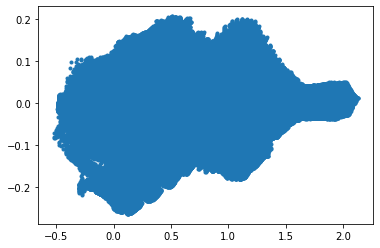

In [62]:
plt.plot(truth['log(Prot)(days)'], error['log(Prot)(days)'], '.');

In [89]:
truth.head()

,log(Age)(Gyr),log(Prot)(days)
0,-1.442631,-0.426228
1,-1.035855,0.025122
2,-0.957876,0.175681
3,-0.277206,0.800040
4,-0.121034,0.890828
